In [1]:
%load_ext rpy2.ipython

In [2]:
%%R 
library("tidyverse")
options(dplyr.width = Inf)
options(readr.num_columns = 0)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [3]:
%%R
# define SB, GATK-SB, Fisher Score calculation functions 
SB_calc = function(ForwardRefCov, ForwardVariantCov, ReverseRefCov, ReverseVariantCov){
    a = ForwardRefCov
    b = ForwardVariantCov
    c = ReverseRefCov
    d = ReverseVariantCov
    bias = abs(b/(a+b) - d/(c+d)) / ((b+d)/(a+b+c+d))
    return (bias)
}

GATK_SB_calc = function(ForwardRefCov, ForwardVariantCov, ReverseRefCov, ReverseVariantCov){
    a = ForwardRefCov
    b = ForwardVariantCov
    c = ReverseRefCov
    d = ReverseVariantCov
    bias1 = b/(a+b)*(c/(c+d))/((a+c)/(a+b+c+d))
    bias2 = d/(c+d)*(a/(a+b))/((a+c)/(a+b+c+d))
    return(pmax(bias1,bias2))
}

Fisher_SB_calc = function(ForwardRefCov, ForwardVariantCov, ReverseRefCov, ReverseVariantCov){
    a = ForwardRefCov
    b = ForwardVariantCov
    c = ReverseRefCov
    d = ReverseVariantCov
    testor = matrix(c(a,b,c,d), ncol=2)
    return (1 - fisher.test(testor)$p.value)
}


In [4]:
%%R
# Read in the three datasets "BC01.variants.0.03.txt", "BC02.variants.0.03.txt", "BC03.variants.0.03.txt". 
# Note that codes below until machine learning were adopted from Nicholas J. Loman. 
barcode1snps=read_tsv("BC01.variants.0.03.txt")
barcode1snps$replica = 'a'

barcode2snps=read_tsv("BC02.variants.0.03.txt")
barcode2snps$replica = 'b'

barcode3snps=read_tsv("BC03.variants.0.03.txt")
barcode3snps$replica = 'c'

In [5]:
%%R
# Merge the three datasets
minion_variants=rbind(barcode1snps, barcode2snps, barcode3snps)

# keep the true and false positives based on prior knowledge 
expectedpositions=read_tsv("expectedpositions.txt")

In [6]:
%%R
minion_variants_state=minion_variants %>%
   left_join(expectedpositions, by=c("Pos" = "Position")) %>%
   filter(State != 'Remove')

# calculate SB, GATK-SB, Fisher Score.
# filter out variants with NaN in any of SB, GATK-SB, Fisher Score 
minion_variants_state %>%
  mutate(Decision = ifelse(grepl("TRUE", State), 1, 0)) %>%
  mutate(SB = SB_calc(ForwardRefCov, ForwardVariantCov, ReverseRefCov, ReverseVariantCov)) %>%
  mutate(GATK_SB = GATK_SB_calc(ForwardRefCov, ForwardVariantCov, ReverseRefCov, ReverseVariantCov)) %>% 
  rowwise() %>% 
  mutate(Fisher_SB = Fisher_SB_calc(ForwardRefCov, ForwardVariantCov, ReverseRefCov, ReverseVariantCov)) %>% 
  filter(!is.na(SB)) %>%
  filter(!is.na(GATK_SB)) %>%
  filter(!is.na(Fisher_SB)) %>%
  write_tsv("minion_variants_state_SB.tsv")

In [ ]:
# machine learning codes below are developed by me. 

In [7]:
import numpy as np 
import pandas as pd 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from itertools import cycle

In [9]:
data = pd.read_csv("minion_variants_state_SB.tsv", sep="\t")
data

,Pos,Qual,Freq,Ref,Base,UngappedCoverage,TotalCoverage,VariantCov,ForwardVariantCov,ReverseVariantCov,RefCov,ForwardRefCov,ReverseRefCov,replica,State,Decision,SB,GATK_SB,Fisher_SB
0,1070,0,0.092933,C,T,1033,1034,96,49,47,936,557,379,a,True,1,0.316808,0.111808,0.872713
1,1129,0,0.038391,G,A,547,550,21,19,2,524,135,389,a,False,0,3.069168,0.127665,1.000000
2,1175,0,0.248945,A,G,474,513,118,105,13,356,55,301,a,True,1,2.469816,0.837596,1.000000
3,1176,0,0.043478,G,A,667,669,29,29,0,638,180,458,a,False,0,3.191388,0.145063,1.000000
4,1183,0,0.031008,C,T,387,391,12,4,8,367,366,1,a,False,0,27.732633,0.908030,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,10342,0,0.030488,A,T,328,332,10,10,0,316,221,95,c,False,0,1.411255,0.044660,0.961916
430,10349,0,0.130435,T,C,483,485,63,36,27,418,151,267,c,True,1,0.768658,0.201184,0.997896
431,10360,0,0.059184,C,T,490,491,29,1,28,461,280,181,c,False,0,2.203523,0.141892,1.000000
432,10361,0,0.123596,T,C,445,465,55,26,29,390,249,141,c,True,1,0.615255,0.176243,0.974563


In [10]:
def plot_KNN_LR_SVM_ROC(data, which_bias="SB"): 
    alpha = np.logspace(-3, 5, 100)
    x = data[['Freq', which_bias]]
    y = data['Decision']
    Freq = data['Freq']
    SB = data[which_bias]
    colors = cycle('gmc')
    plt.figure(figsize=(7, 6), facecolor='w')
    models = [['KNN', KNeighborsClassifier(n_neighbors=5)],
              ['LogisticRegression', LogisticRegressionCV(Cs=alpha, penalty='l2', cv=5)],
              ['SVM(Linear)', GridSearchCV(SVC(kernel='linear', decision_function_shape='ovo'), param_grid={'C': alpha}, cv=5)]]
    for (name, model), color in zip(models, colors):
        model.fit(x, y)
        if hasattr(model, 'predict_proba'):
            y_score = model.predict_proba(x)[:,1]
        else:
            y_score = model.decision_function(x)
        fpr, tpr, thresholds = metrics.roc_curve(y, y_score)
        auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, c=color, lw=2, alpha=0.7, label="{0}, AUC={1:.3f}".format(name, auc))
    
    fpr, tpr, thresholds = metrics.roc_curve(y, Freq)
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, c='b', lw=2, alpha=0.7, label="{0}, AUC={1:.3f}".format("Frequency", auc))
    
    fpr, tpr, thresholds = metrics.roc_curve(y, SB)
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, c='y', lw=2, alpha=0.7, label="{0}, AUC={1:.3f}".format("Strand bias", auc))
    
    plt.plot((0, 1), (0, 1), c='#808080', lw=2, ls='--', alpha=0.7)
    plt.xlim((-0.01, 1.02))
    plt.ylim((-0.01, 1.02))
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.grid(b=True, ls=':')
    plt.legend(loc='lower right', fancybox=True, framealpha=0.8, edgecolor='#303030', fontsize=12)
    plt.title("ROC Frequency " + which_bias, fontsize=16)
    plt.savefig("ROC Frequency " + which_bias + ".pdf", format="pdf")

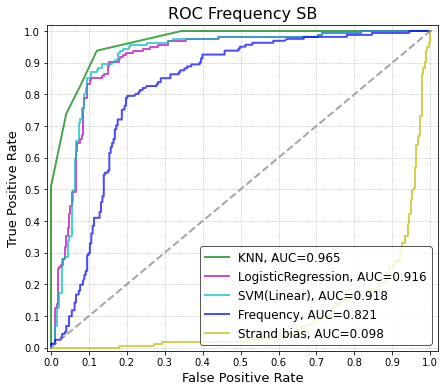

In [11]:
plot_KNN_LR_SVM_ROC(data, which_bias="SB")

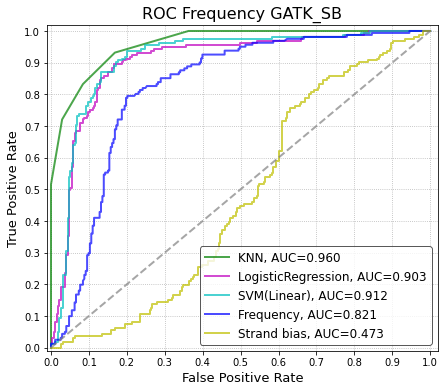

In [12]:
plot_KNN_LR_SVM_ROC(data, which_bias="GATK_SB")

In [ ]:
plot_KNN_LR_SVM_ROC(data, which_bias="Fisher_SB")